In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from data_loader import get_cifar100_loaders
from evaluation_utils import (evaluate_model, plot_confusion_matrix,
                              visualize_misclassified, get_cifar100_class_names)

In [2]:
def train_model(model, train_loader, test_loader, num_epochs, learning_rate, device, model_name="swin_transformer"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01) # AdamW is common for transformers
    # A scheduler like CosineAnnealingLR or StepLR is beneficial
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Adjust step_size for 20 epochs

    model.to(device)
    best_accuracy = 0.0
    model_save_path = f'{model_name}_cifar100_best.pth'

    train_acc_history = []
    test_acc_history = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for i, (inputs, labels) in enumerate(train_iterator):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_iterator.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc_train = 100.0 * correct_train / total_train
        train_acc_history.append(epoch_acc_train)

        model.eval()
        correct_test = 0
        total_test = 0
        test_iterator = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for inputs, labels in test_iterator:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        epoch_acc_test = 100.0 * correct_test / total_test
        test_acc_history.append(epoch_acc_test)
        end_time = time.time()
        epoch_duration = end_time - start_time
        current_lr = scheduler.get_last_lr()[0]

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc_train:.2f}% | '
              f'Test Acc: {epoch_acc_test:.2f}% | LR: {current_lr:.6f} | '
              f'Duration: {epoch_duration:.2f}s')

        scheduler.step()

        if epoch_acc_test > best_accuracy:
            best_accuracy = epoch_acc_test
            try:
                torch.save(model.state_dict(), model_save_path)
                print(f'>>> Best model saved to {model_save_path} with Test Accuracy: {best_accuracy:.2f}%')
            except Exception as e:
                 print(f"Lỗi khi lưu model: {e}")

    print('Finished Training')
    print(f'Best Validation Accuracy achieved during training: {best_accuracy:.2f}%')

    print(f"Loading best model state from {model_save_path} for final evaluation...")
    try:
        model.load_state_dict(torch.load(model_save_path))
    except Exception as e:
        print(f"Could not load best model state: {e}. Evaluating with the final model state.")

    return model, train_acc_history, test_acc_history

Sử dụng thiết bị: cuda
Đang tải dữ liệu CIFAR-100 (resize: 224x224)...
Đã tải xong CIFAR-100.
Số lượng ảnh Train: 50000
Số lượng ảnh Test: 10000
Kích thước ảnh: 224x224
Sử dụng Data Augmentation: True
Khởi tạo 8_SWINT pre-trained model...
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /home/ngo/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


100%|██████████| 108M/108M [00:03<00:00, 36.2MB/s] 


Replaced Swin Transformer classifier head (model.head) with Linear(768, 100)
Bắt đầu fine-tuning 8_SWINT...


Epoch 1/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.27it/s]


Epoch 1/20 | Train Loss: 4.6371 | Train Acc: 0.97% | Test Acc: 1.00% | LR: 0.001000 | Duration: 499.08s
>>> Best model saved to 8_SwinT_cifar100_best.pth with Test Accuracy: 1.00%


Epoch 2/20 [Val]: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s]


Epoch 2/20 | Train Loss: 4.6201 | Train Acc: 0.96% | Test Acc: 1.00% | LR: 0.001000 | Duration: 501.86s


Epoch 3/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Epoch 3/20 | Train Loss: 4.6196 | Train Acc: 0.93% | Test Acc: 1.00% | LR: 0.001000 | Duration: 501.64s


Epoch 4/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch 4/20 | Train Loss: 4.6172 | Train Acc: 0.92% | Test Acc: 1.00% | LR: 0.001000 | Duration: 500.78s


Epoch 5/20 [Val]: 100%|██████████| 313/313 [00:31<00:00, 10.09it/s]


Epoch 5/20 | Train Loss: 4.6156 | Train Acc: 0.99% | Test Acc: 1.00% | LR: 0.001000 | Duration: 501.56s


Epoch 6/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Epoch 6/20 | Train Loss: 4.6149 | Train Acc: 0.88% | Test Acc: 1.00% | LR: 0.001000 | Duration: 500.62s


Epoch 7/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.13it/s]


Epoch 7/20 | Train Loss: 4.6136 | Train Acc: 1.08% | Test Acc: 1.00% | LR: 0.001000 | Duration: 500.63s


Epoch 8/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch 8/20 | Train Loss: 4.6075 | Train Acc: 0.99% | Test Acc: 1.00% | LR: 0.000100 | Duration: 500.75s


Epoch 9/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch 9/20 | Train Loss: 4.6064 | Train Acc: 0.97% | Test Acc: 1.00% | LR: 0.000100 | Duration: 499.53s


Epoch 10/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.12it/s]


Epoch 10/20 | Train Loss: 4.6063 | Train Acc: 0.98% | Test Acc: 1.00% | LR: 0.000100 | Duration: 499.94s


Epoch 11/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.24it/s]


Epoch 11/20 | Train Loss: 4.6060 | Train Acc: 0.91% | Test Acc: 1.00% | LR: 0.000100 | Duration: 500.38s


Epoch 12/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.13it/s]


Epoch 12/20 | Train Loss: 4.6062 | Train Acc: 0.99% | Test Acc: 1.00% | LR: 0.000100 | Duration: 500.66s


Epoch 13/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.28it/s]


Epoch 13/20 | Train Loss: 4.6062 | Train Acc: 0.94% | Test Acc: 1.00% | LR: 0.000100 | Duration: 499.25s


Epoch 14/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.23it/s]


Epoch 14/20 | Train Loss: 4.6062 | Train Acc: 0.92% | Test Acc: 1.00% | LR: 0.000100 | Duration: 500.87s


Epoch 15/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.16it/s]


Epoch 15/20 | Train Loss: 4.6057 | Train Acc: 0.98% | Test Acc: 1.00% | LR: 0.000010 | Duration: 501.24s


Epoch 16/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


Epoch 16/20 | Train Loss: 4.6055 | Train Acc: 0.99% | Test Acc: 1.00% | LR: 0.000010 | Duration: 500.07s


Epoch 17/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.19it/s]


Epoch 17/20 | Train Loss: 4.6055 | Train Acc: 1.00% | Test Acc: 1.00% | LR: 0.000010 | Duration: 501.60s


Epoch 18/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.26it/s]


Epoch 18/20 | Train Loss: 4.6054 | Train Acc: 1.00% | Test Acc: 1.00% | LR: 0.000010 | Duration: 498.93s


Epoch 19/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.25it/s]


Epoch 19/20 | Train Loss: 4.6053 | Train Acc: 0.98% | Test Acc: 1.00% | LR: 0.000010 | Duration: 499.33s


Epoch 20/20 [Val]: 100%|██████████| 313/313 [00:30<00:00, 10.16it/s]


Epoch 20/20 | Train Loss: 4.6054 | Train Acc: 0.93% | Test Acc: 1.00% | LR: 0.000010 | Duration: 502.78s
Finished Training
Best Validation Accuracy achieved during training: 1.00%
Loading best model state from 8_SwinT_cifar100_best.pth for final evaluation...

--- Performing Final Evaluation on 8_SWINT ---
Evaluating on test set...


  0%|          | 0/313 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

        apple       0.00      0.00      0.00       100
aquarium_fish       0.00      0.00      0.00       100
         baby       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.00      0.00      0.00       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
       bottle       0.00      0.00      0.00       100
         bowl       0.00      0.00      0.00       100
          boy       0.00      0.00      0.00       100
       bridge       0.00      0.00      0.00       100
          bus       0.00      0.00      0.00       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
          can       0.00      0.00      

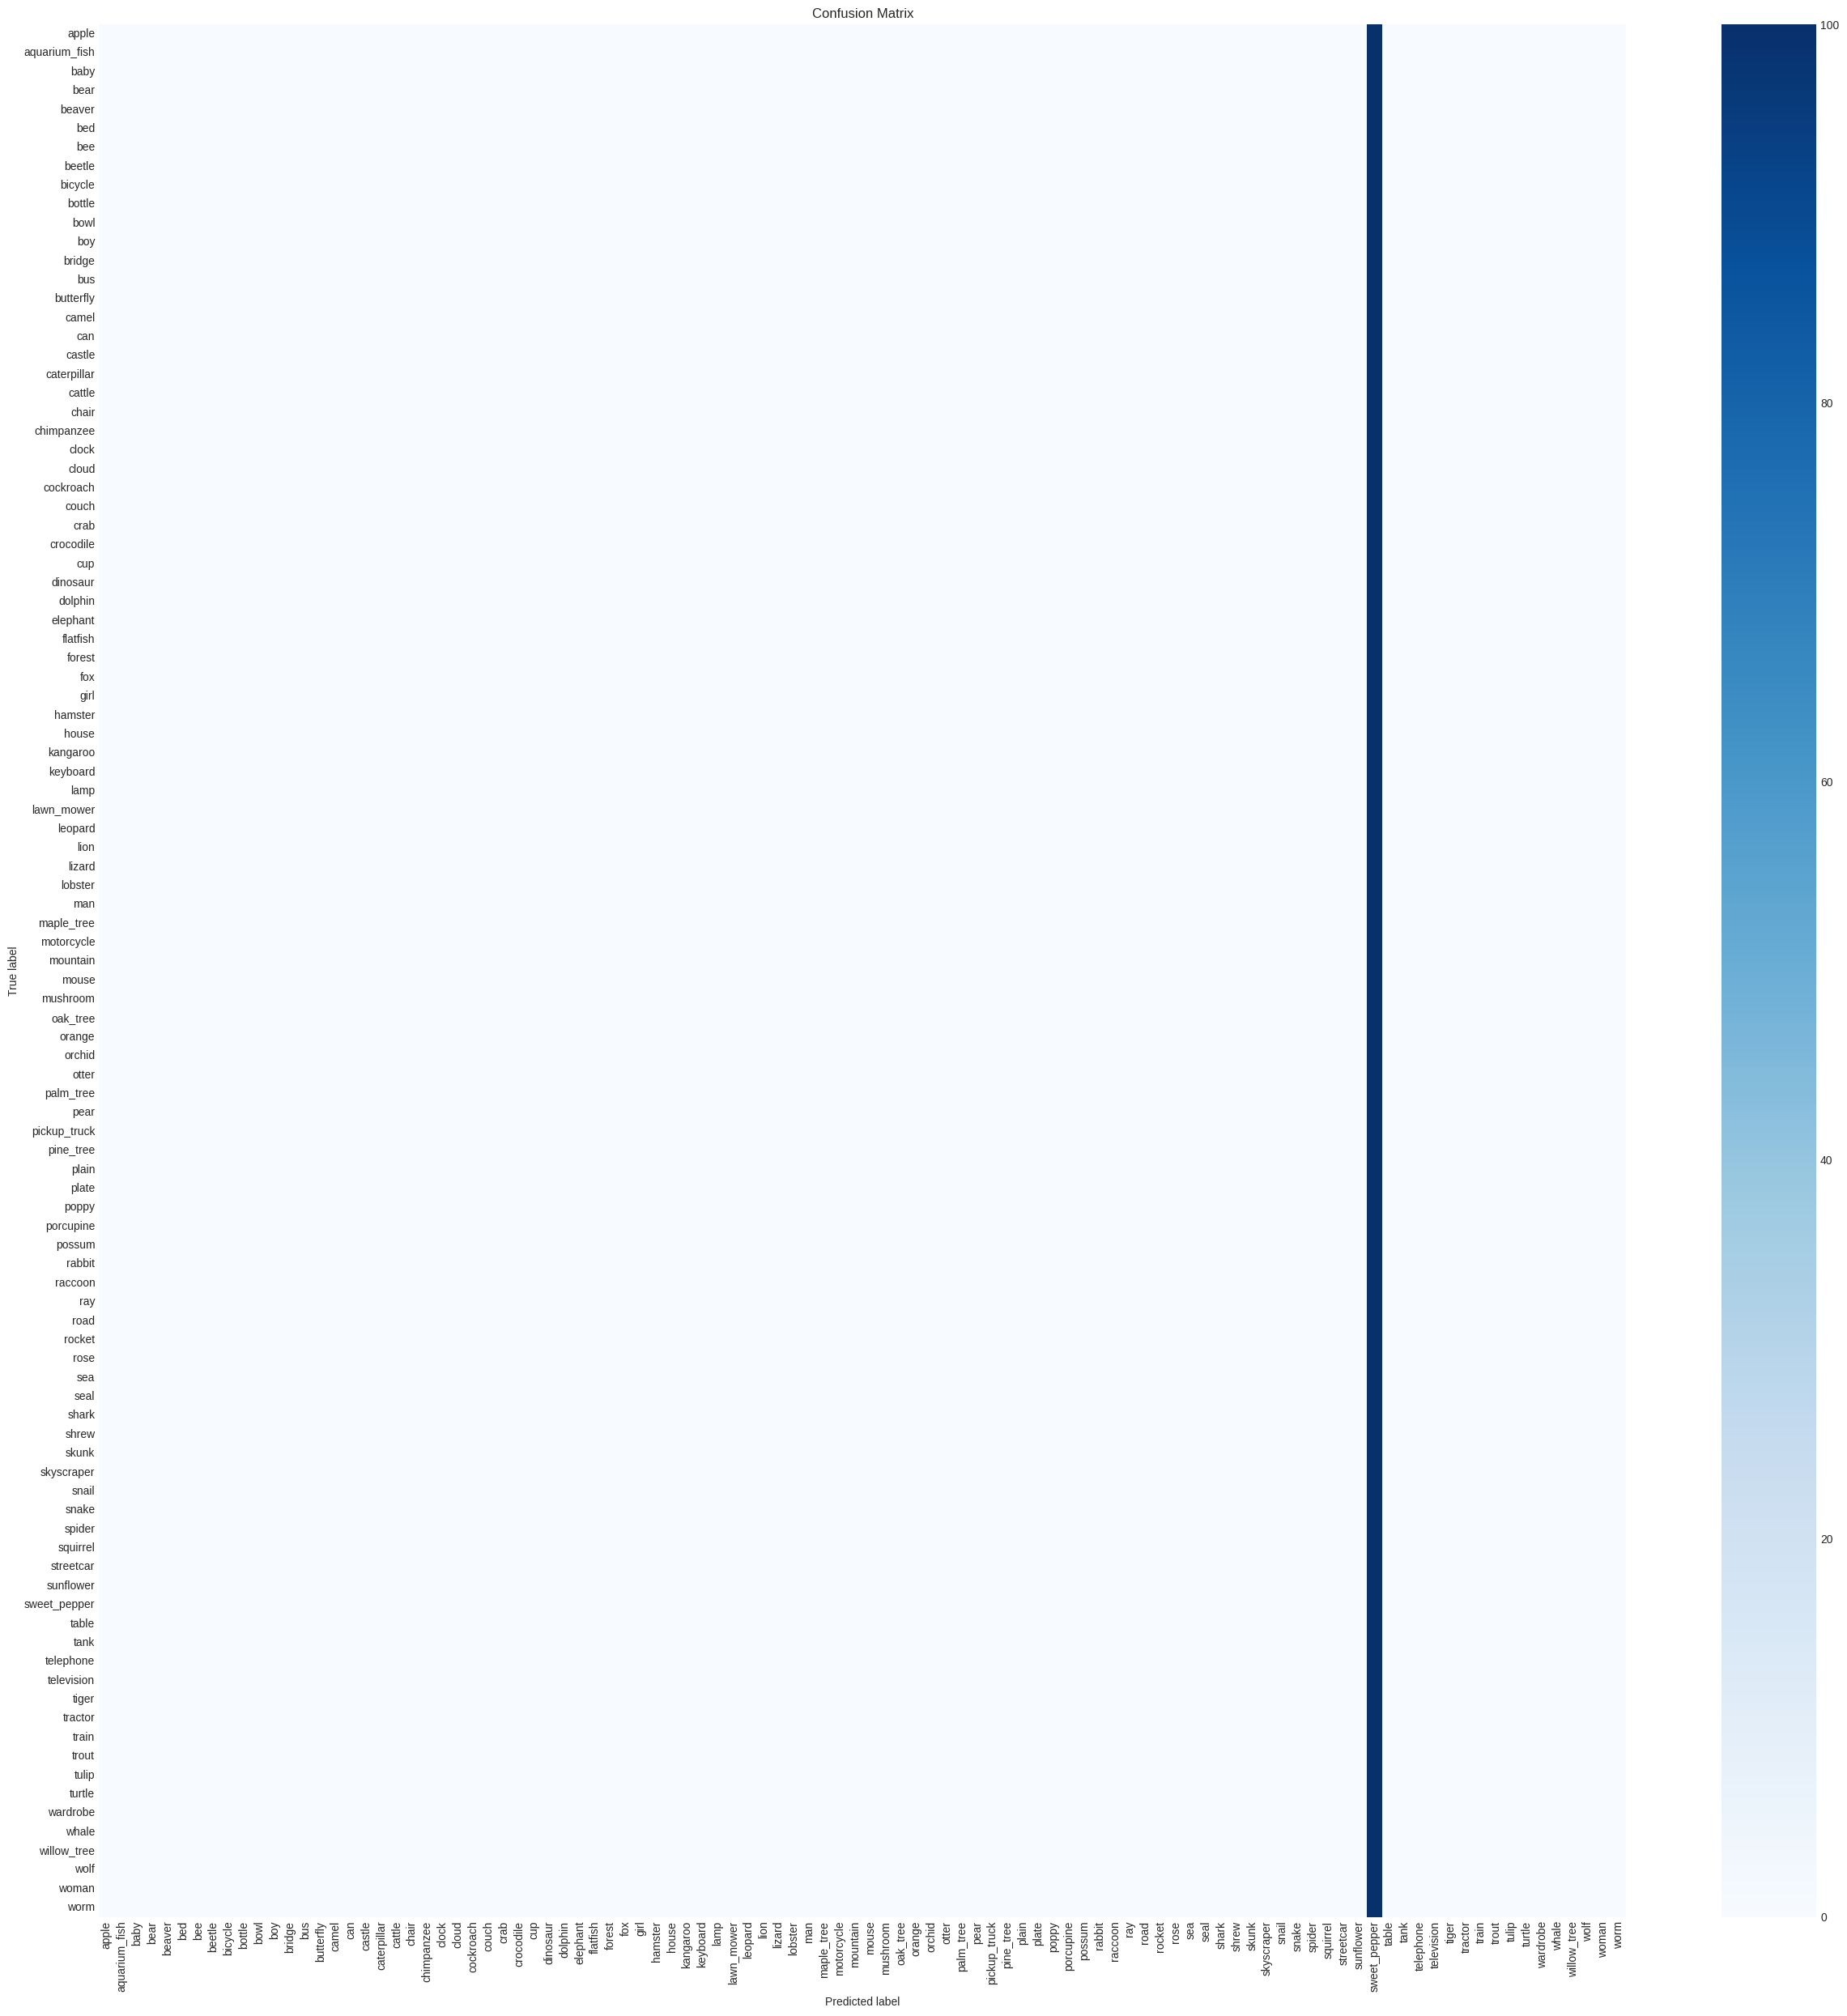


Searching for 25 misclassified images...


  0%|          | 0/313 [00:00<?, ?it/s]

Visualizing 25 misclassified images...
Misclassified images visualization saved to 8_SwinT_misclassified_25.png


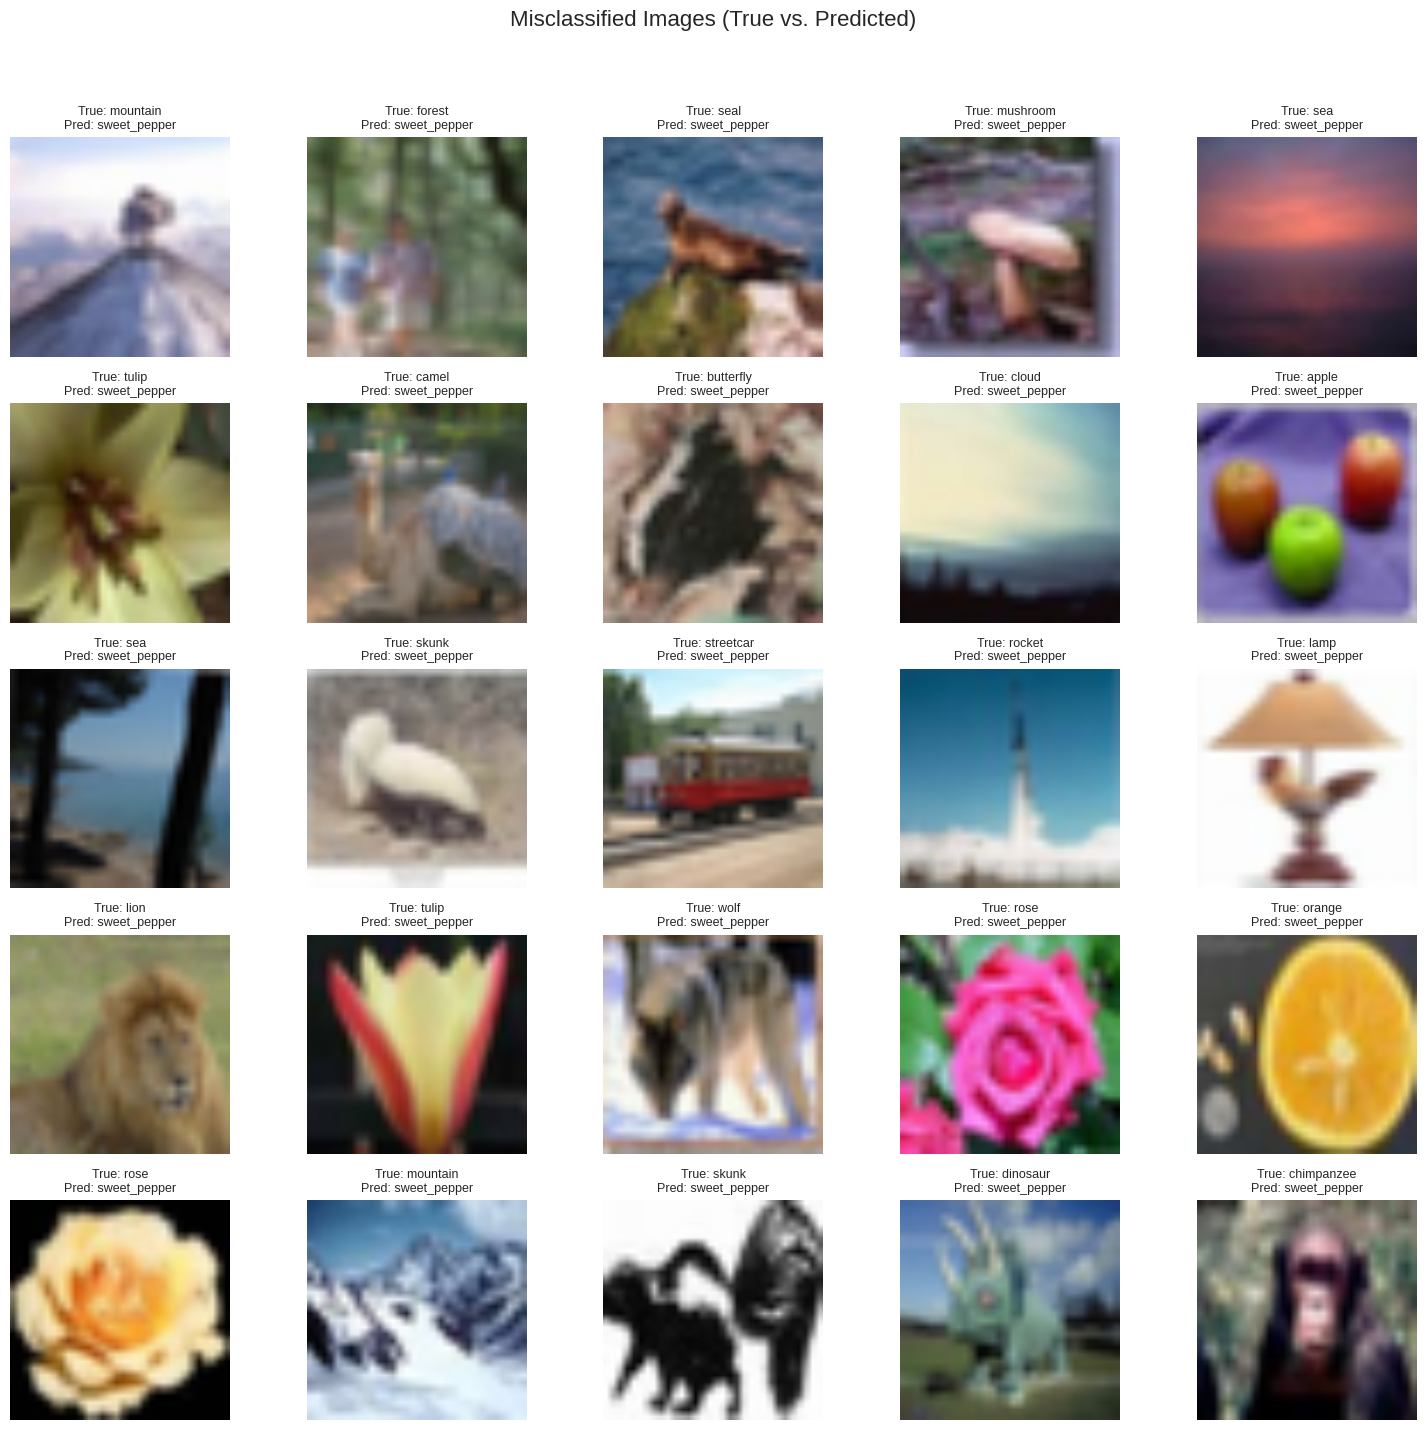

Accuracy history plot saved to 8_SwinT_accuracy_history.png


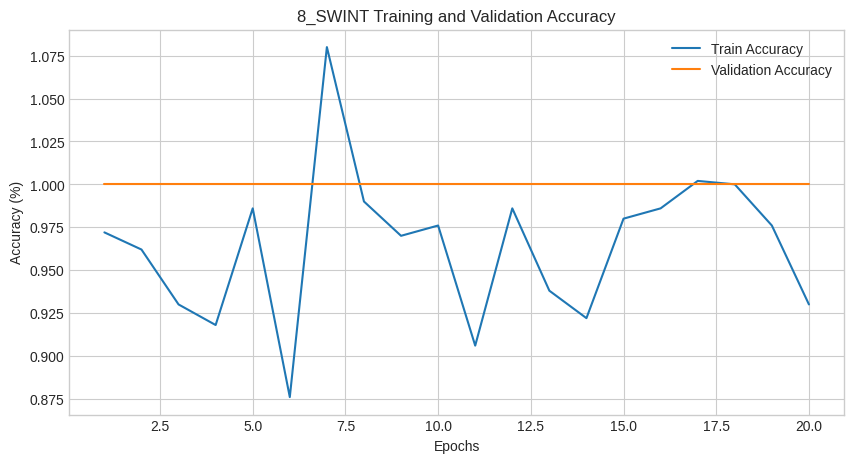

In [3]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001   # Start with a small LR for fine-tuning transformers
IMG_SIZE = 224
USE_AUGMENTATION = True
DATA_DIR = './data_cifar100'
NUM_WORKERS = 4
MODEL_NAME = "8_SwinT"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

class_names = get_cifar100_class_names(DATA_DIR)
num_classes = len(class_names)

print(f"Đang tải dữ liệu CIFAR-100 (resize: {IMG_SIZE}x{IMG_SIZE})...")
train_loader, test_loader, _ = get_cifar100_loaders(
    batch_size=BATCH_SIZE,
    data_dir=DATA_DIR,
    img_size=IMG_SIZE,
    use_augmentation=USE_AUGMENTATION,
    num_workers=NUM_WORKERS
)

if train_loader is None:
    print("Không thể tải dữ liệu. Kết thúc chương trình.")
    exit()

print(f"Khởi tạo {MODEL_NAME.upper()} pre-trained model...")
# Load a pre-trained Swin Transformer model
try:
    weights = models.Swin_T_Weights.IMAGENET1K_V1
    model = models.swin_t(weights=weights)
except Exception as e:
    print(f"Error loading model {MODEL_NAME}: {e}")
    exit()

# Adapt the classifier head
# In Swin Transformer, the classifier head is typically called 'head'
if hasattr(model, 'head') and isinstance(model.head, nn.Linear):
    num_ftrs = model.head.in_features
    model.head = nn.Linear(num_ftrs, num_classes)
    print(f"Replaced Swin Transformer classifier head (model.head) with Linear({num_ftrs}, {num_classes})")
else:
    print("Could not automatically find and replace the Swin Transformer classifier head.")
    print("Please inspect the model structure (print(model)) and adapt manually.")
    exit()

print(f"Bắt đầu fine-tuning {MODEL_NAME.upper()}...")
trained_model, train_history, test_history = train_model(
    model, train_loader, test_loader, NUM_EPOCHS, LEARNING_RATE, device, model_name=MODEL_NAME
)

print(f"\n--- Performing Final Evaluation on {MODEL_NAME.upper()} ---")
final_metrics = evaluate_model(trained_model, test_loader, device, num_classes, class_names)

if 'confusion_matrix' in final_metrics:
    plot_confusion_matrix(final_metrics['confusion_matrix'], class_names,
                            filename=f'{MODEL_NAME}_confusion_matrix.png',
                            figsize=(25, 25))

visualize_misclassified(trained_model, test_loader, device, class_names,
                        num_images=25,
                        filename_prefix=f'{MODEL_NAME}_misclassified')

plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_history, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), test_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'{MODEL_NAME.upper()} Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'{MODEL_NAME}_accuracy_history.png')
print(f"Accuracy history plot saved to {MODEL_NAME}_accuracy_history.png")
plt.show()
